In [1]:
import os
import argparse
from utils import *
from tqdm import tqdm
from torch import optim
from model import my_model
import torch.nn.functional as F
import pandas as pd
from utils import get_logger
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
import os
import scipy.sparse as sparse
import anndata
import seaborn as sns
import time
sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3
sns.set_style("white")
np.random.seed(0)

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==1.24.1 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


In [2]:
cluster_num =20
gnnlayers = 3
lr = 1e-3
dims = [150]
epochs=400
sigma=0.01 

In [3]:
section_id = 'V1'
input_dir = os.path.join('F:\\王海月\\代码\\UGIMC\\Data\\Breast_Cancer', section_id)
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
cell_type_indeces = np.load(input_dir + '/cell_types.npy')
adata.obs['Ground Truth'] = cell_type_indeces
adata.obs['Ground Truth'] = adata.obs['Ground Truth'].astype('int')
adata.obs['Ground Truth'] = adata.obs['Ground Truth'].astype('category')

reading F:\王海月\代码\UGIMC\Data\Breast_Cancer\V1\filtered_feature_bc_matrix.h5
 (0:00:01)


In [4]:
from image_feature import ImageFeature, image_crop
from pathlib import Path
save_path = 'results'
save_path_image_crop = Path(os.path.join(save_path, 'image_crop', f'{section_id}'))
save_path_image_crop.mkdir(parents=True, exist_ok=True)
adata = image_crop(adata, crop_size=112, save_path=save_path_image_crop, verbose=False)
adata = ImageFeature(adata, pca_components=200, verbose=True, seeds=2023).extract_image_features()
adata

Tiling Image: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The image feature is added to adata.obsm['Image_Feature']
The pca result of image features is added to adata.obsm['image_feat_pca']


AnnData object with n_obs × n_vars = 3798 × 14977
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Ground Truth', 'image_col', 'image_row', 'slice_path'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial', 'image_feature', 'aug_image_feature1', 'aug_image_feature2', 'image_feat_pca'

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.8384017944335938 seconds
Jaccard graph constructed in 4.414304256439209 seconds
Wrote graph to binary file in 0.07360696792602539 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.863238
After 2 runs, maximum modularity is Q = 0.864877
After 16 runs, maximum modularity is Q = 0.866502
Louvain completed 36 runs in 4.960357427597046 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 12.929605722427368 seconds


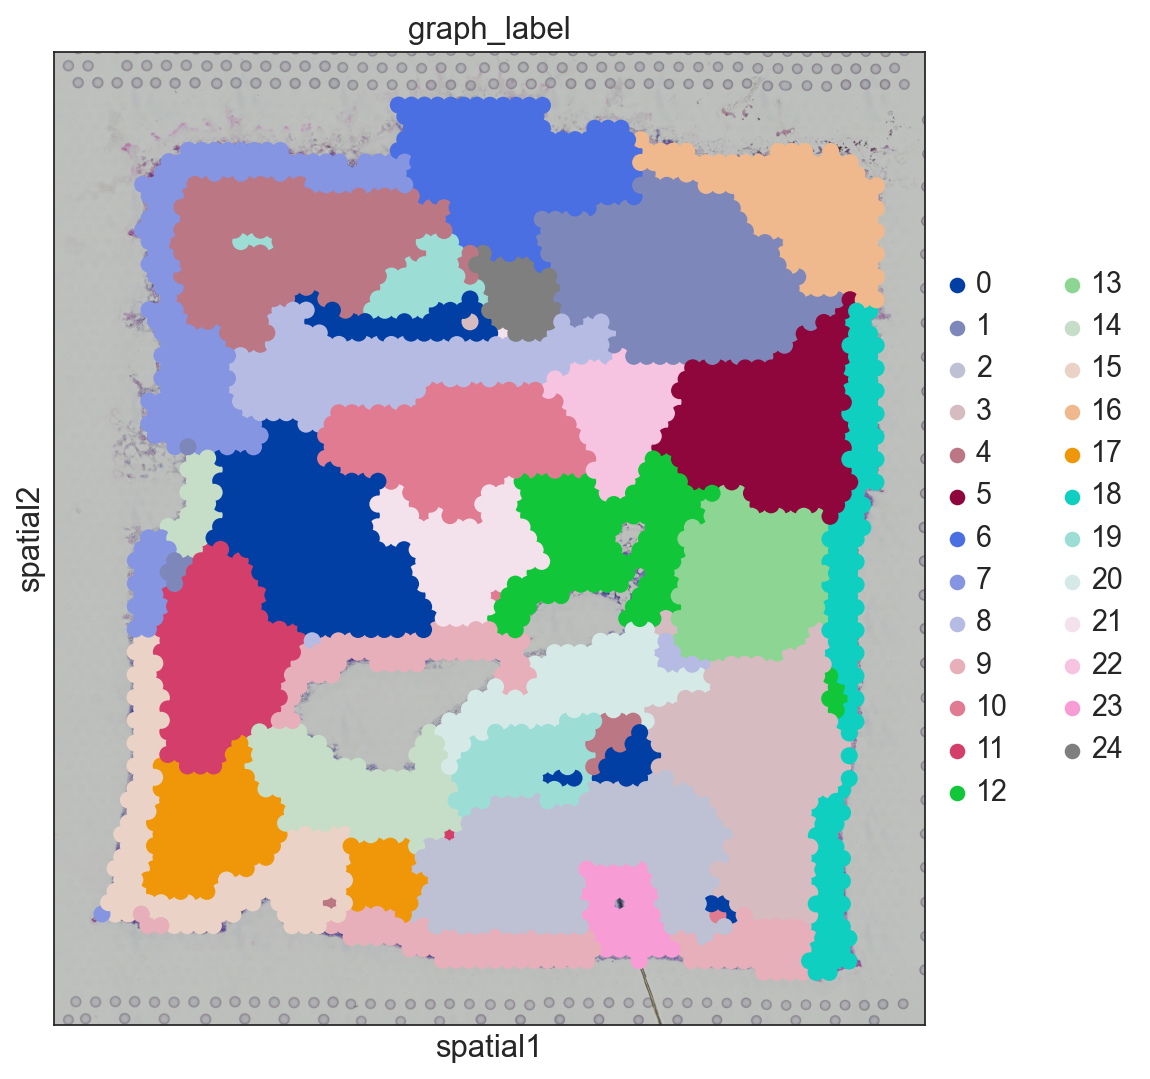

In [7]:
import phenograph
graph_label, _, _ = phenograph.cluster(adata.obsm['image_feat_pca'])
adata.obs['graph_label'] = graph_label
adata.obs['graph_label'] = adata.obs['graph_label'].astype('category')
sc.pl.spatial(adata, color='graph_label', size=2)

In [8]:
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score 
ARI = adjusted_rand_score(adata.obs['graph_label'], pd.Categorical(adata.obs['Ground Truth']).codes)
# NMI = normalized_mutual_info_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.31


In [9]:
from sklearn.metrics import pairwise_distances
morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_similarity[morphological_similarity < 0] = 0

In [10]:
n_spot = len(adata.obs['graph_label'] )
n_neighbor = 8
from sklearn.metrics import pairwise_distances

morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_network = np.zeros((n_spot, n_spot))
for i in range(n_spot):
    vec = morphological_similarity[i, :]
    distance = vec.argsort()[:: -1]
    for t in range(n_neighbor + 1):
        y = distance[t]
        morphological_network[i, y] = morphological_similarity[i, y]

In [11]:
morphological_similaritys = np.nan_to_num(morphological_similarity)

In [12]:
contains_nan = np.isnan(morphological_similaritys ).any()
contains_nan

False

In [13]:
from sklearn.cluster import SpectralClustering

In [14]:
n_clusters = 20  # 聚类数量
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels = spectral.fit_predict(morphological_network)
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score 
ARI = adjusted_rand_score(labels, pd.Categorical(adata.obs['Ground Truth']).codes)
# NMI = normalized_mutual_info_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.35


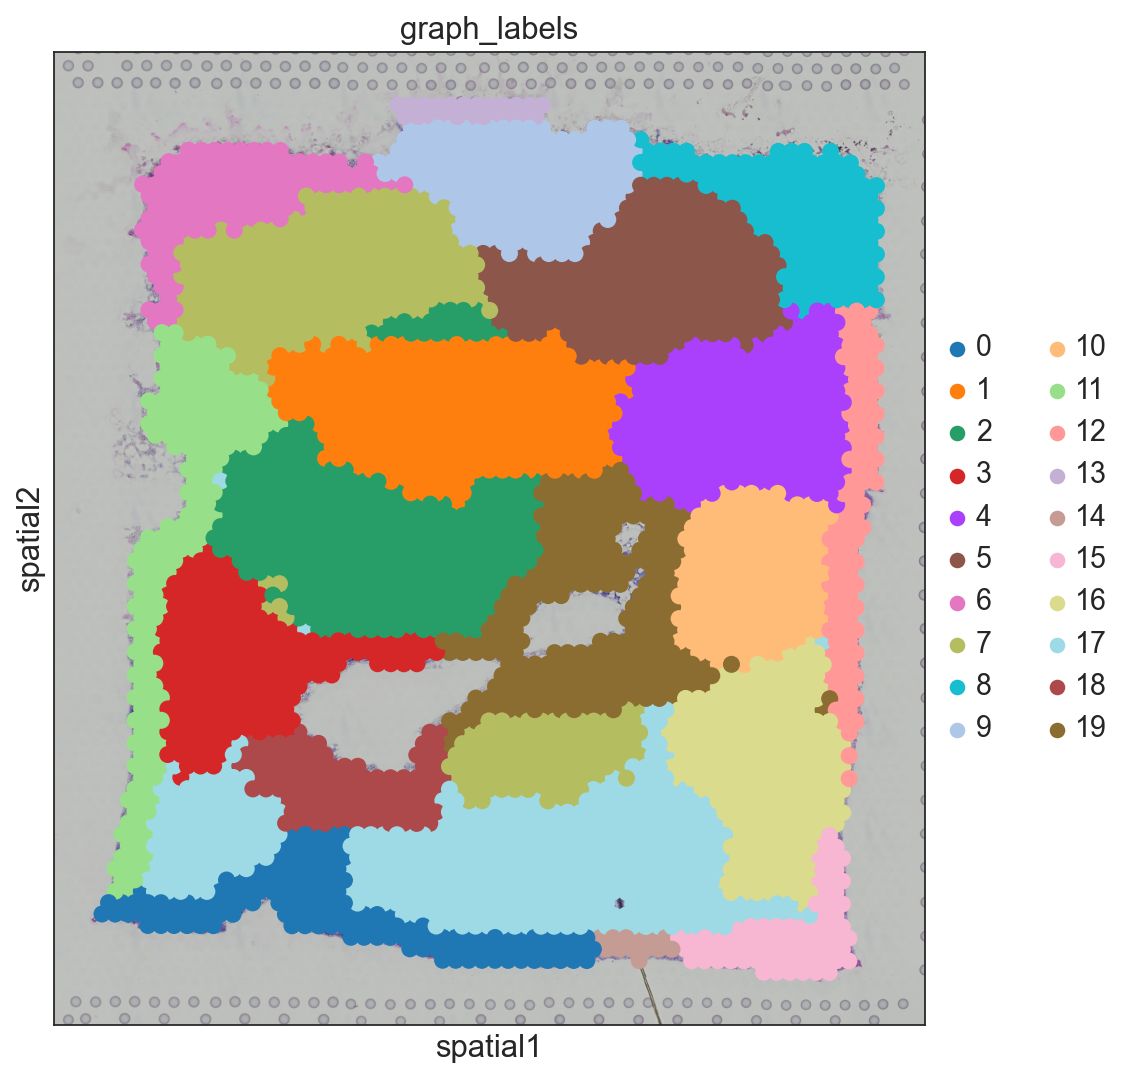

In [15]:
adata.obs['graph_labels'] = labels
adata.obs['graph_labels'] = adata.obs['graph_labels'].astype('category')
sc.pl.spatial(adata, color='graph_labels', size=2)

In [16]:
# sc.pp.filter_genes(adata, min_cells=10)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000)
hvg_filter = adata.var['highly_variable']
sc.pp.normalize_total(adata, inplace=True)
adata = adata[:, hvg_filter]
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e4)
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6, ratio=0.3)
feat = np.array(enhanced_adata.X)
adj = cell_spatial.A
true_labels = pd.Categorical(adata.obs['Ground Truth']).codes

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)

Median distance to closest cell = 273.7480593538519
num_nbrs: 3000


In [17]:
features = feat
adj = sp.csr_matrix(adj)
adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
adj.eliminate_zeros()
print('Laplacian Smoothing...')
adj_norm_s = preprocess_graph(adj, gnnlayers, norm='sym', renorm=True)
sm_fea_s = features
for a in adj_norm_s:
    sm_fea_s = a.dot(sm_fea_s)
sm_fea_s = torch.FloatTensor(sm_fea_s)
adj_1st = (adj + sp.eye(adj.shape[0])).toarray()
acc_list = []
nmi_list = []
ari_list = []
f1_list = []
best_acc=0
best_nmi=0
best_ari=0
best_f1=0
device='cpu'
logger = get_logger()
for seed in range(1):
    setup_seed(seed)
    best_accs, best_nmis, best_aris, best_f1s, prediect_labels = clustering(sm_fea_s, true_labels, cluster_num)
    print(best_ari)
    model = my_model([features.shape[1]] + dims)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model = model.to(device)
    inx = sm_fea_s.to(device)
    target = torch.FloatTensor(adj_1st).to(device)
    criterion = torch.nn.MSELoss(reduction='sum')

    print('Start Training...')
    logger.info('--------------------Start Training--------------------')
    for epoch in tqdm(range(epochs)):
        model.train()
        z1, z2,decoder_out= model(inx, is_train=True, sigma=sigma)
        S = z1 @ z2.T
        loss = 0.0001* (0.5 * F.mse_loss(S, target) + 0.5 * F.mse_loss(S, target_m) )+ criterion(decoder_out, inx)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            model.eval()
            z1, z2,decoder_out = model(inx, is_train=False, sigma=sigma)
            hidden_emb = (z1 + z2) / 2

            acc, nmi, ari, f1, predict_labels = clustering(hidden_emb, true_labels, cluster_num)
            if ari >= best_ari:
                best_acc = acc
                best_nmi = nmi
                best_ari = ari
                best_f1 = f1
                best_label = predict_labels
                best_h = hidden_emb.detach().numpy()
                df_S = pd.DataFrame(S.detach().numpy())
                df_l = pd.DataFrame(best_label)
                df_X = pd.DataFrame(decoder_out.detach().numpy())


    logger.info('--------------------Training over--------------------')
    logger.info(
        """ ACC {:.2f} NMI {:.2f} ARI {:.2f} f_score {:.2f} """.format(best_acc, best_nmi, best_ari, best_f1))
    print(best_acc, best_nmi, best_ari, best_f1)
    enhanced_adata.obsm['denoised']=decoder_out.detach().numpy()
    enhanced_adata.obs['stMuGC_label']=best_label
    enhanced_adata.obsm['feature']=hidden_emb.detach().numpy()
    enhanced_adata.obsm['S']=S.detach().numpy()

Laplacian Smoothing...
<class 'torch.Tensor'>


2025-04-15 16:59:34 - root - INFO: - --------------------Start Training--------------------


0
Start Training...


  0%|                                                                                                                                                                                                          | 0/400 [00:00<?, ?it/s]

<class 'torch.Tensor'>


  2%|████▊                                                                                                                                                                                            | 10/400 [00:06<03:28,  1.87it/s]

<class 'torch.Tensor'>


  5%|█████████▋                                                                                                                                                                                       | 20/400 [00:11<03:05,  2.05it/s]

<class 'torch.Tensor'>


  8%|██████████████▍                                                                                                                                                                                  | 30/400 [00:18<03:34,  1.72it/s]

<class 'torch.Tensor'>


 10%|███████████████████▎                                                                                                                                                                             | 40/400 [00:24<03:13,  1.86it/s]

<class 'torch.Tensor'>


 12%|████████████████████████▏                                                                                                                                                                        | 50/400 [00:30<03:12,  1.81it/s]

<class 'torch.Tensor'>


 15%|████████████████████████████▉                                                                                                                                                                    | 60/400 [00:36<02:48,  2.02it/s]

<class 'torch.Tensor'>


 18%|█████████████████████████████████▊                                                                                                                                                               | 70/400 [00:43<02:52,  1.91it/s]

<class 'torch.Tensor'>


 20%|██████████████████████████████████████▌                                                                                                                                                          | 80/400 [00:50<02:41,  1.98it/s]

<class 'torch.Tensor'>


 22%|███████████████████████████████████████████▍                                                                                                                                                     | 90/400 [00:58<02:45,  1.87it/s]

<class 'torch.Tensor'>


 25%|████████████████████████████████████████████████                                                                                                                                                | 100/400 [01:04<02:28,  2.02it/s]

<class 'torch.Tensor'>


 28%|████████████████████████████████████████████████████▊                                                                                                                                           | 110/400 [01:10<02:30,  1.93it/s]

<class 'torch.Tensor'>


 30%|█████████████████████████████████████████████████████████▌                                                                                                                                      | 120/400 [01:16<02:23,  1.96it/s]

<class 'torch.Tensor'>


 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                 | 130/400 [01:22<02:11,  2.06it/s]

<class 'torch.Tensor'>


 35%|███████████████████████████████████████████████████████████████████▏                                                                                                                            | 140/400 [01:29<02:18,  1.88it/s]

<class 'torch.Tensor'>


 38%|████████████████████████████████████████████████████████████████████████                                                                                                                        | 150/400 [01:34<01:56,  2.15it/s]

<class 'torch.Tensor'>


 40%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 160/400 [01:40<01:56,  2.06it/s]

<class 'torch.Tensor'>


 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 170/400 [01:46<01:50,  2.08it/s]

<class 'torch.Tensor'>


 45%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 180/400 [01:51<01:40,  2.18it/s]

<class 'torch.Tensor'>


 48%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 190/400 [01:57<01:38,  2.13it/s]

<class 'torch.Tensor'>


 50%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 200/400 [02:03<01:42,  1.96it/s]

<class 'torch.Tensor'>


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 210/400 [02:09<01:36,  1.96it/s]

<class 'torch.Tensor'>


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 220/400 [02:15<01:23,  2.15it/s]

<class 'torch.Tensor'>


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 230/400 [02:20<01:16,  2.22it/s]

<class 'torch.Tensor'>


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 240/400 [02:25<01:11,  2.23it/s]

<class 'torch.Tensor'>


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 250/400 [02:31<01:10,  2.12it/s]

<class 'torch.Tensor'>


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 260/400 [02:37<01:07,  2.08it/s]

<class 'torch.Tensor'>


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 270/400 [02:42<01:02,  2.08it/s]

<class 'torch.Tensor'>


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 280/400 [02:48<01:00,  1.97it/s]

<class 'torch.Tensor'>


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 290/400 [02:54<00:48,  2.28it/s]

<class 'torch.Tensor'>


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 300/400 [02:58<00:34,  2.88it/s]

<class 'torch.Tensor'>


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 310/400 [03:03<00:36,  2.49it/s]

<class 'torch.Tensor'>


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 320/400 [03:08<00:29,  2.72it/s]

<class 'torch.Tensor'>


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 330/400 [03:12<00:25,  2.79it/s]

<class 'torch.Tensor'>


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 340/400 [03:16<00:22,  2.70it/s]

<class 'torch.Tensor'>


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 350/400 [03:20<00:18,  2.76it/s]

<class 'torch.Tensor'>


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 360/400 [03:25<00:14,  2.78it/s]

<class 'torch.Tensor'>


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 370/400 [03:29<00:10,  2.80it/s]

<class 'torch.Tensor'>


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 380/400 [03:33<00:07,  2.80it/s]

<class 'torch.Tensor'>


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 390/400 [03:37<00:03,  2.84it/s]

<class 'torch.Tensor'>


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [03:42<00:00,  1.80it/s]
2025-04-15 17:03:16 - root - INFO: - --------------------Training over--------------------
2025-04-15 17:03:16 - root - INFO: -  ACC 65.56 NMI 69.61 ARI 64.50 f_score 47.67 


65.56 69.61 64.5 47.67


In [18]:
adata.obs['stMuGC_label']=best_label.astype(str)

... storing 'stMuGC_label' as categorical


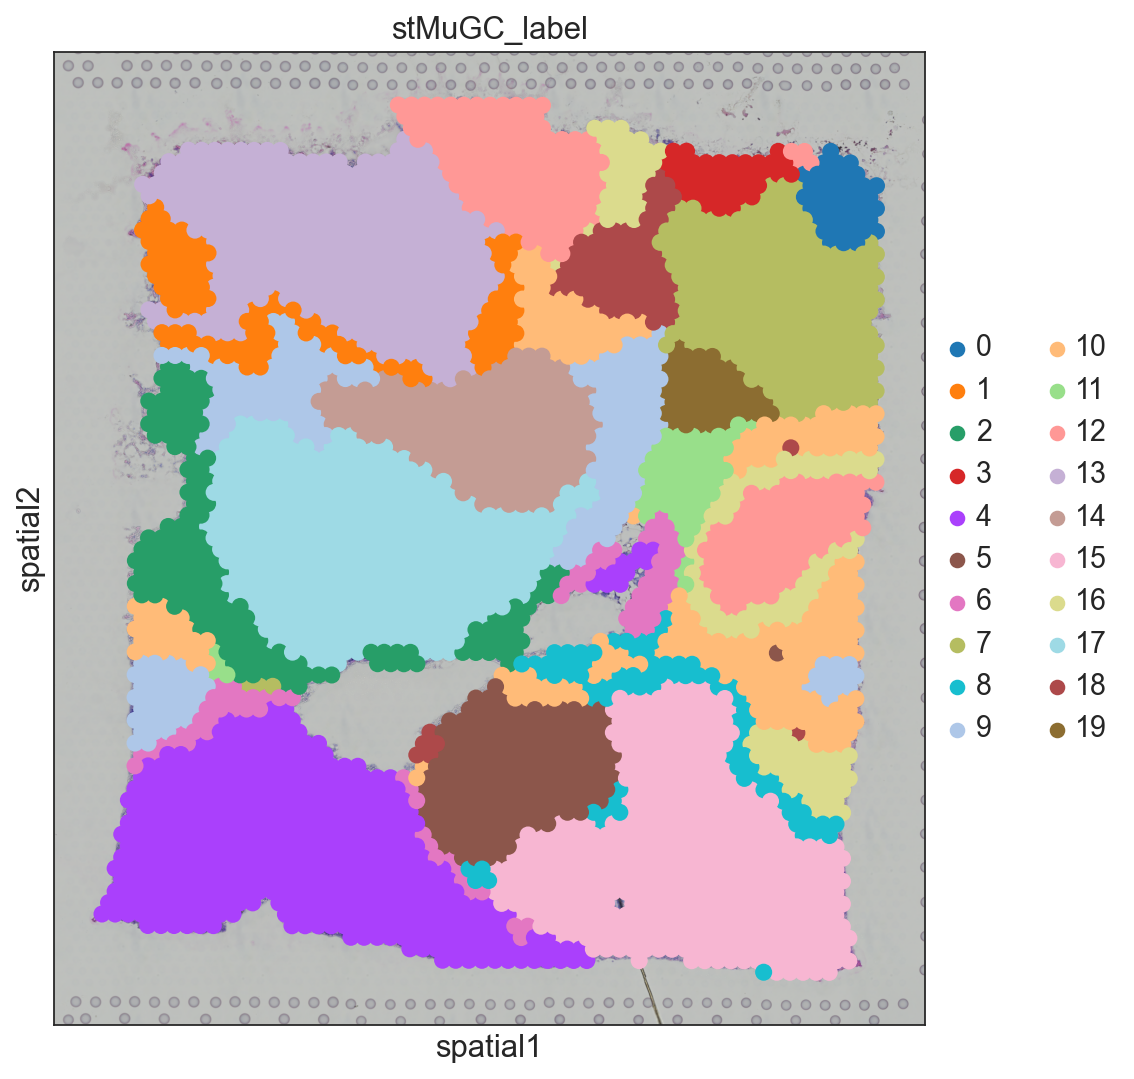

In [19]:
sc.pl.spatial(adata, color='stMuGC_label', size=2)

In [20]:
ARI = adjusted_rand_score(best_label, pd.Categorical(enhanced_adata.obs['Ground Truth']).codes)
# NMI = normalized_mutual_info_score(obs_df['mclust'], obs_df['Ground Truth'])
print('Adjusted rand index = %.3f' %ARI)

Adjusted rand index = 0.645


In [21]:
denoised_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6, ratio=0.2)
denoised_adata.X = enhanced_adata.obsm['denoised']
denoised_adata.obs["Ground Truth"]=enhanced_adata.obs["Ground Truth"]
denoised_adata.obs['stMuGC_label']=best_label
denoised_adata.obsm['feature']=hidden_emb.detach().numpy()
denoised_adata.obsm['S']=S.detach().numpy()


Median distance to closest cell = 273.7480593538519
num_nbrs: 3000


In [25]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
denoised_adata.X = imputer.fit_transform(denoised_adata.X)
sc.pp.pca(denoised_adata, n_comps=50)
sc.pp.neighbors(denoised_adata, use_rep='X_pca')
sc.tl.leiden(denoised_adata, resolution=0.715)
sc.tl.umap(denoised_adata)

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


2025-04-15 17:13:20 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D607031DC0>
2025-04-15 17:13:20 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D606D52E50>
2025-04-15 17:13:20 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D6070101C0>
2025-04-15 17:13:21 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D607100520>
2025-04-15 17:13:21 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D60469C4F0>
2025-04-15 17:13:22 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D606E7E370>
2025-04-15 17:13:22 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D588FF49D0>
2025-04-15 17:13:22 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D607453850>
2025-04-15 17:13

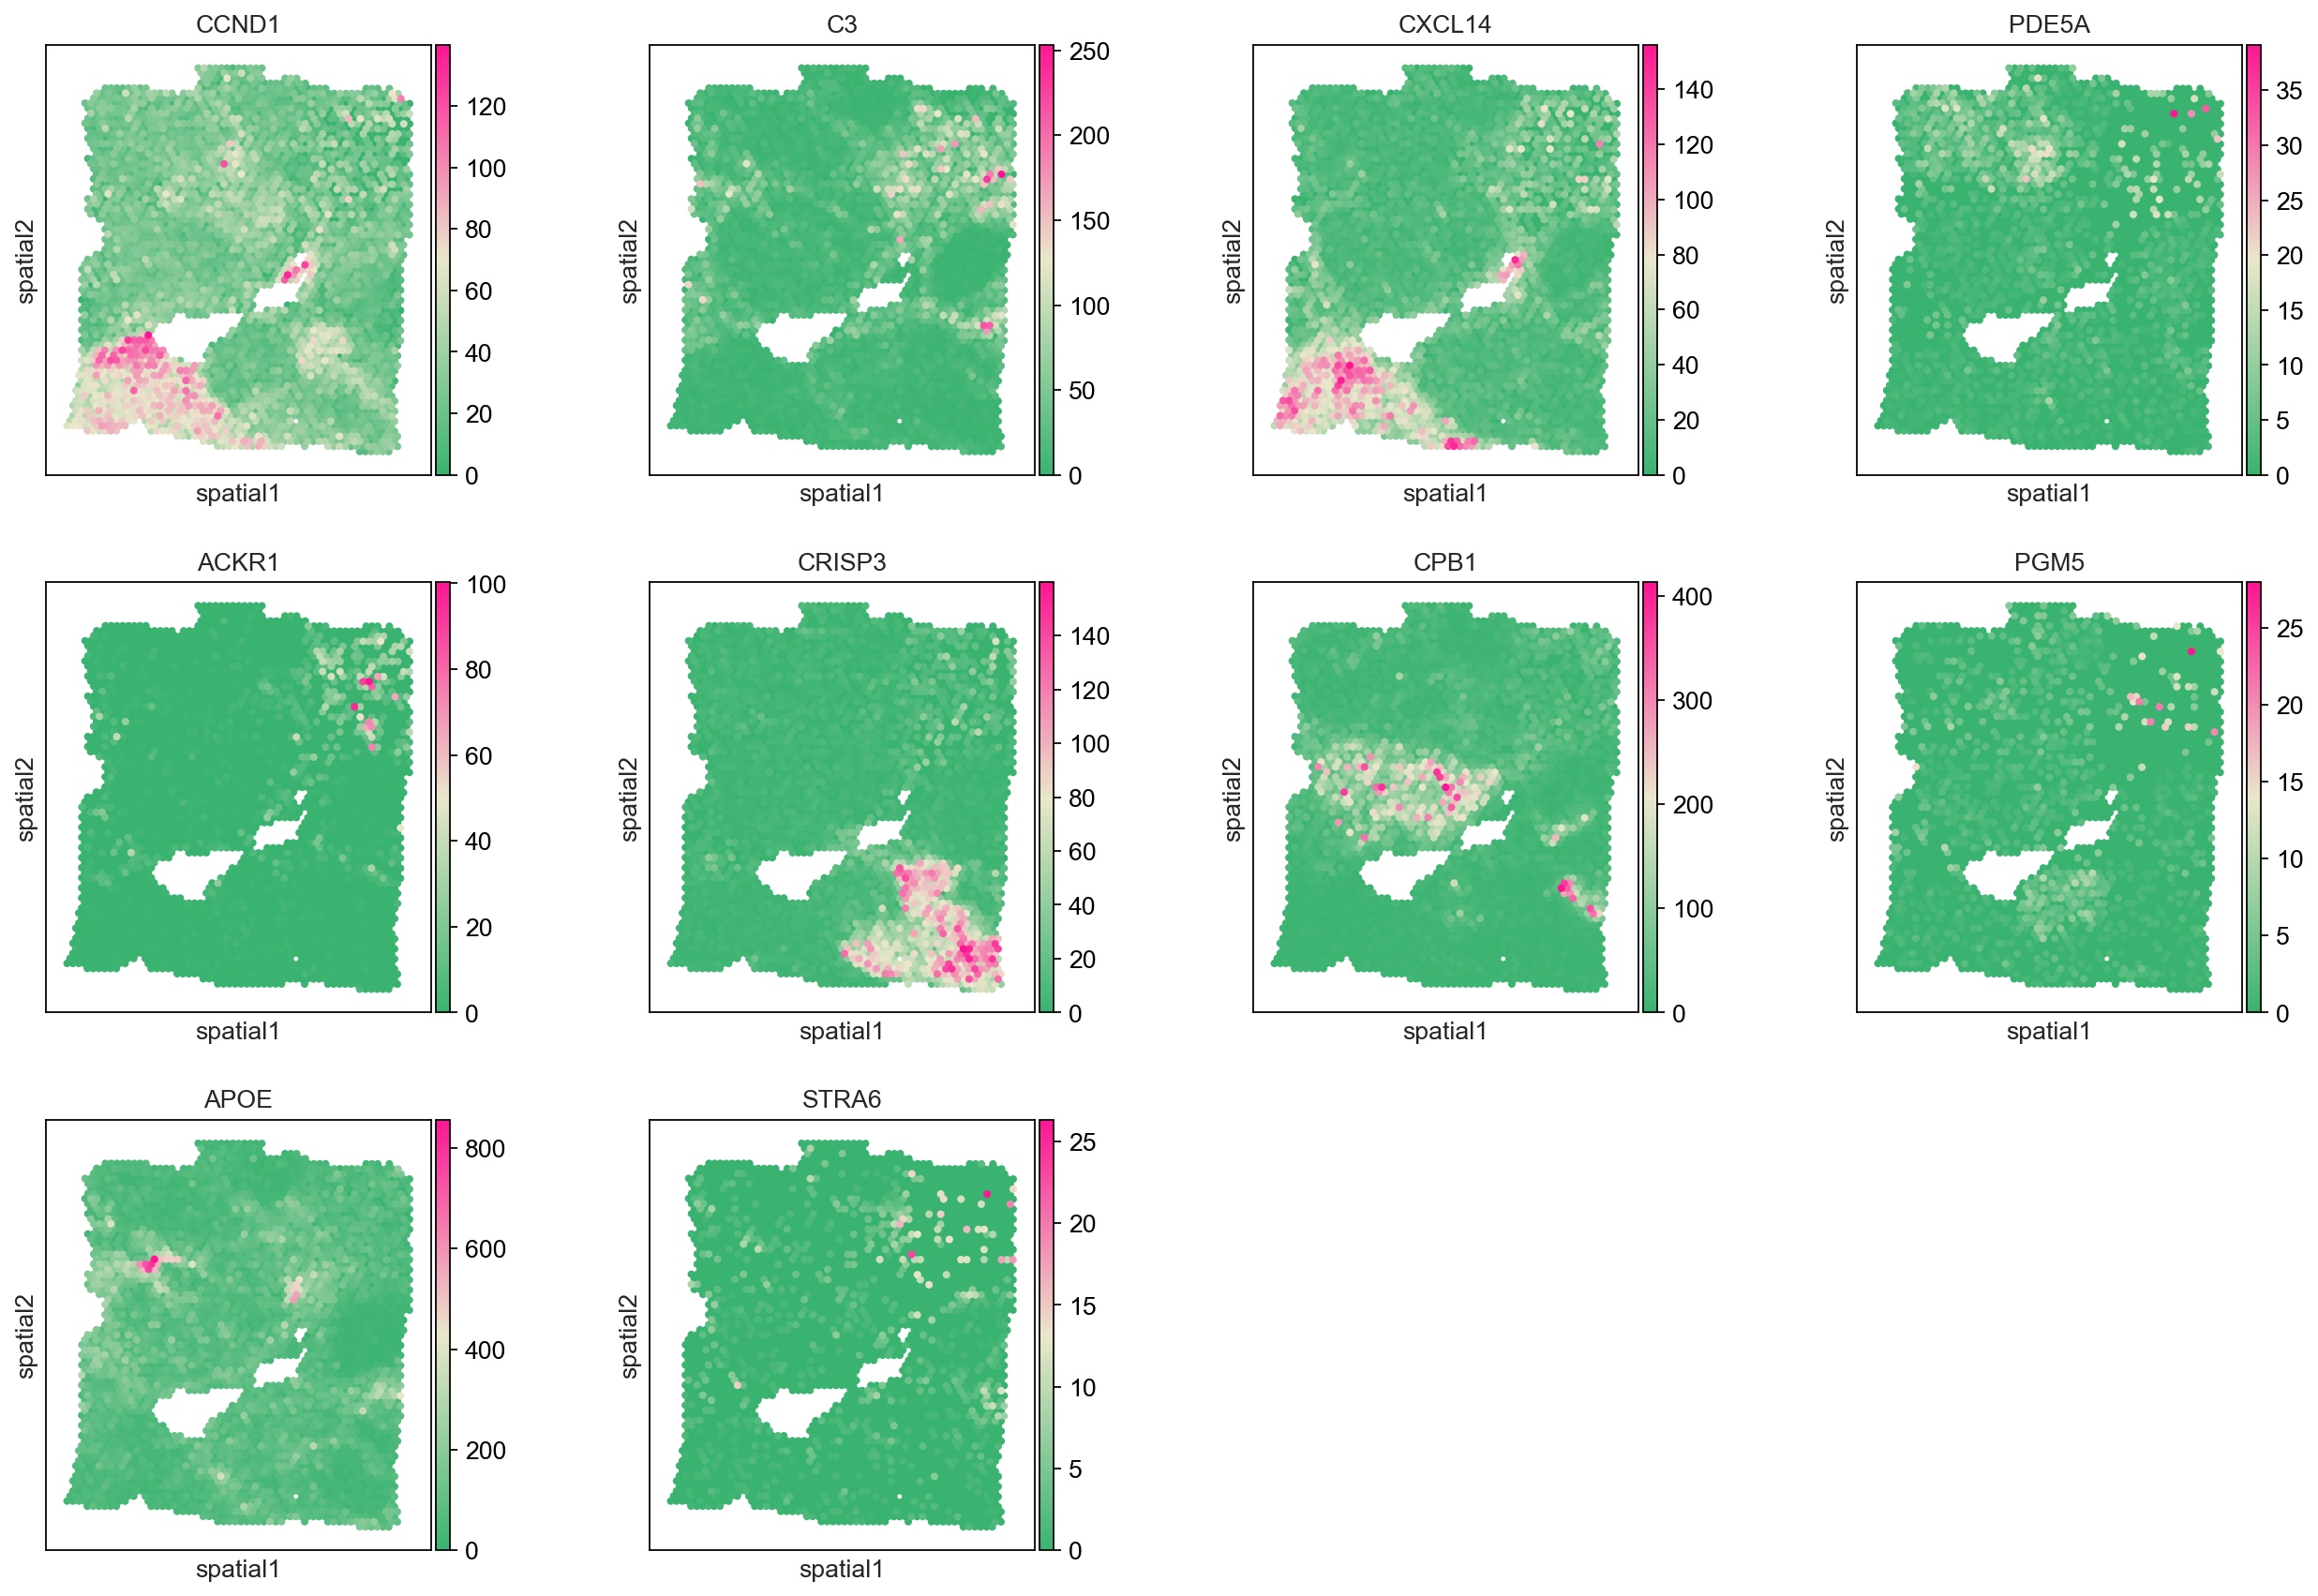

In [26]:
# Gene
import matplotlib.colors as clr#'MALAT1','AGR2','CCND1','CXCL14','CPB1','S100G', 'IFT122', 'HEBP1', 'TPD52','PCED1B','WASHC5','ITPR1','FAM234B','CD47'
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=500, frameon=True, vector_friendly=False, fontsize=12, figsize=None, color_map=None, format='eps', facecolor=None, transparent=True, ipython_format='png2x')
sc.pl.spatial(adata, color=['CCND1','C3','CXCL14','PDE5A','ACKR1','CRISP3','CPB1','PGM5','APOE','STRA6'],color_map=color_self,  alpha_img=0, size=2,save = 'Obreast10_9')#,save = 'breast10_9'

2025-04-15 17:13:42 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D606DA5C40>
2025-04-15 17:13:43 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D60473C520>
2025-04-15 17:13:43 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D58903A310>
2025-04-15 17:13:43 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D608D4DD30>
2025-04-15 17:13:44 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D6087E94F0>
2025-04-15 17:13:44 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D5F785EFD0>
2025-04-15 17:13:44 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D60879A760>
2025-04-15 17:13:45 - matplotlib.colorbar - DEBUG: - locator: <matplotlib.ticker.AutoLocator object at 0x000001D606E29A30>
2025-04-15 17:13

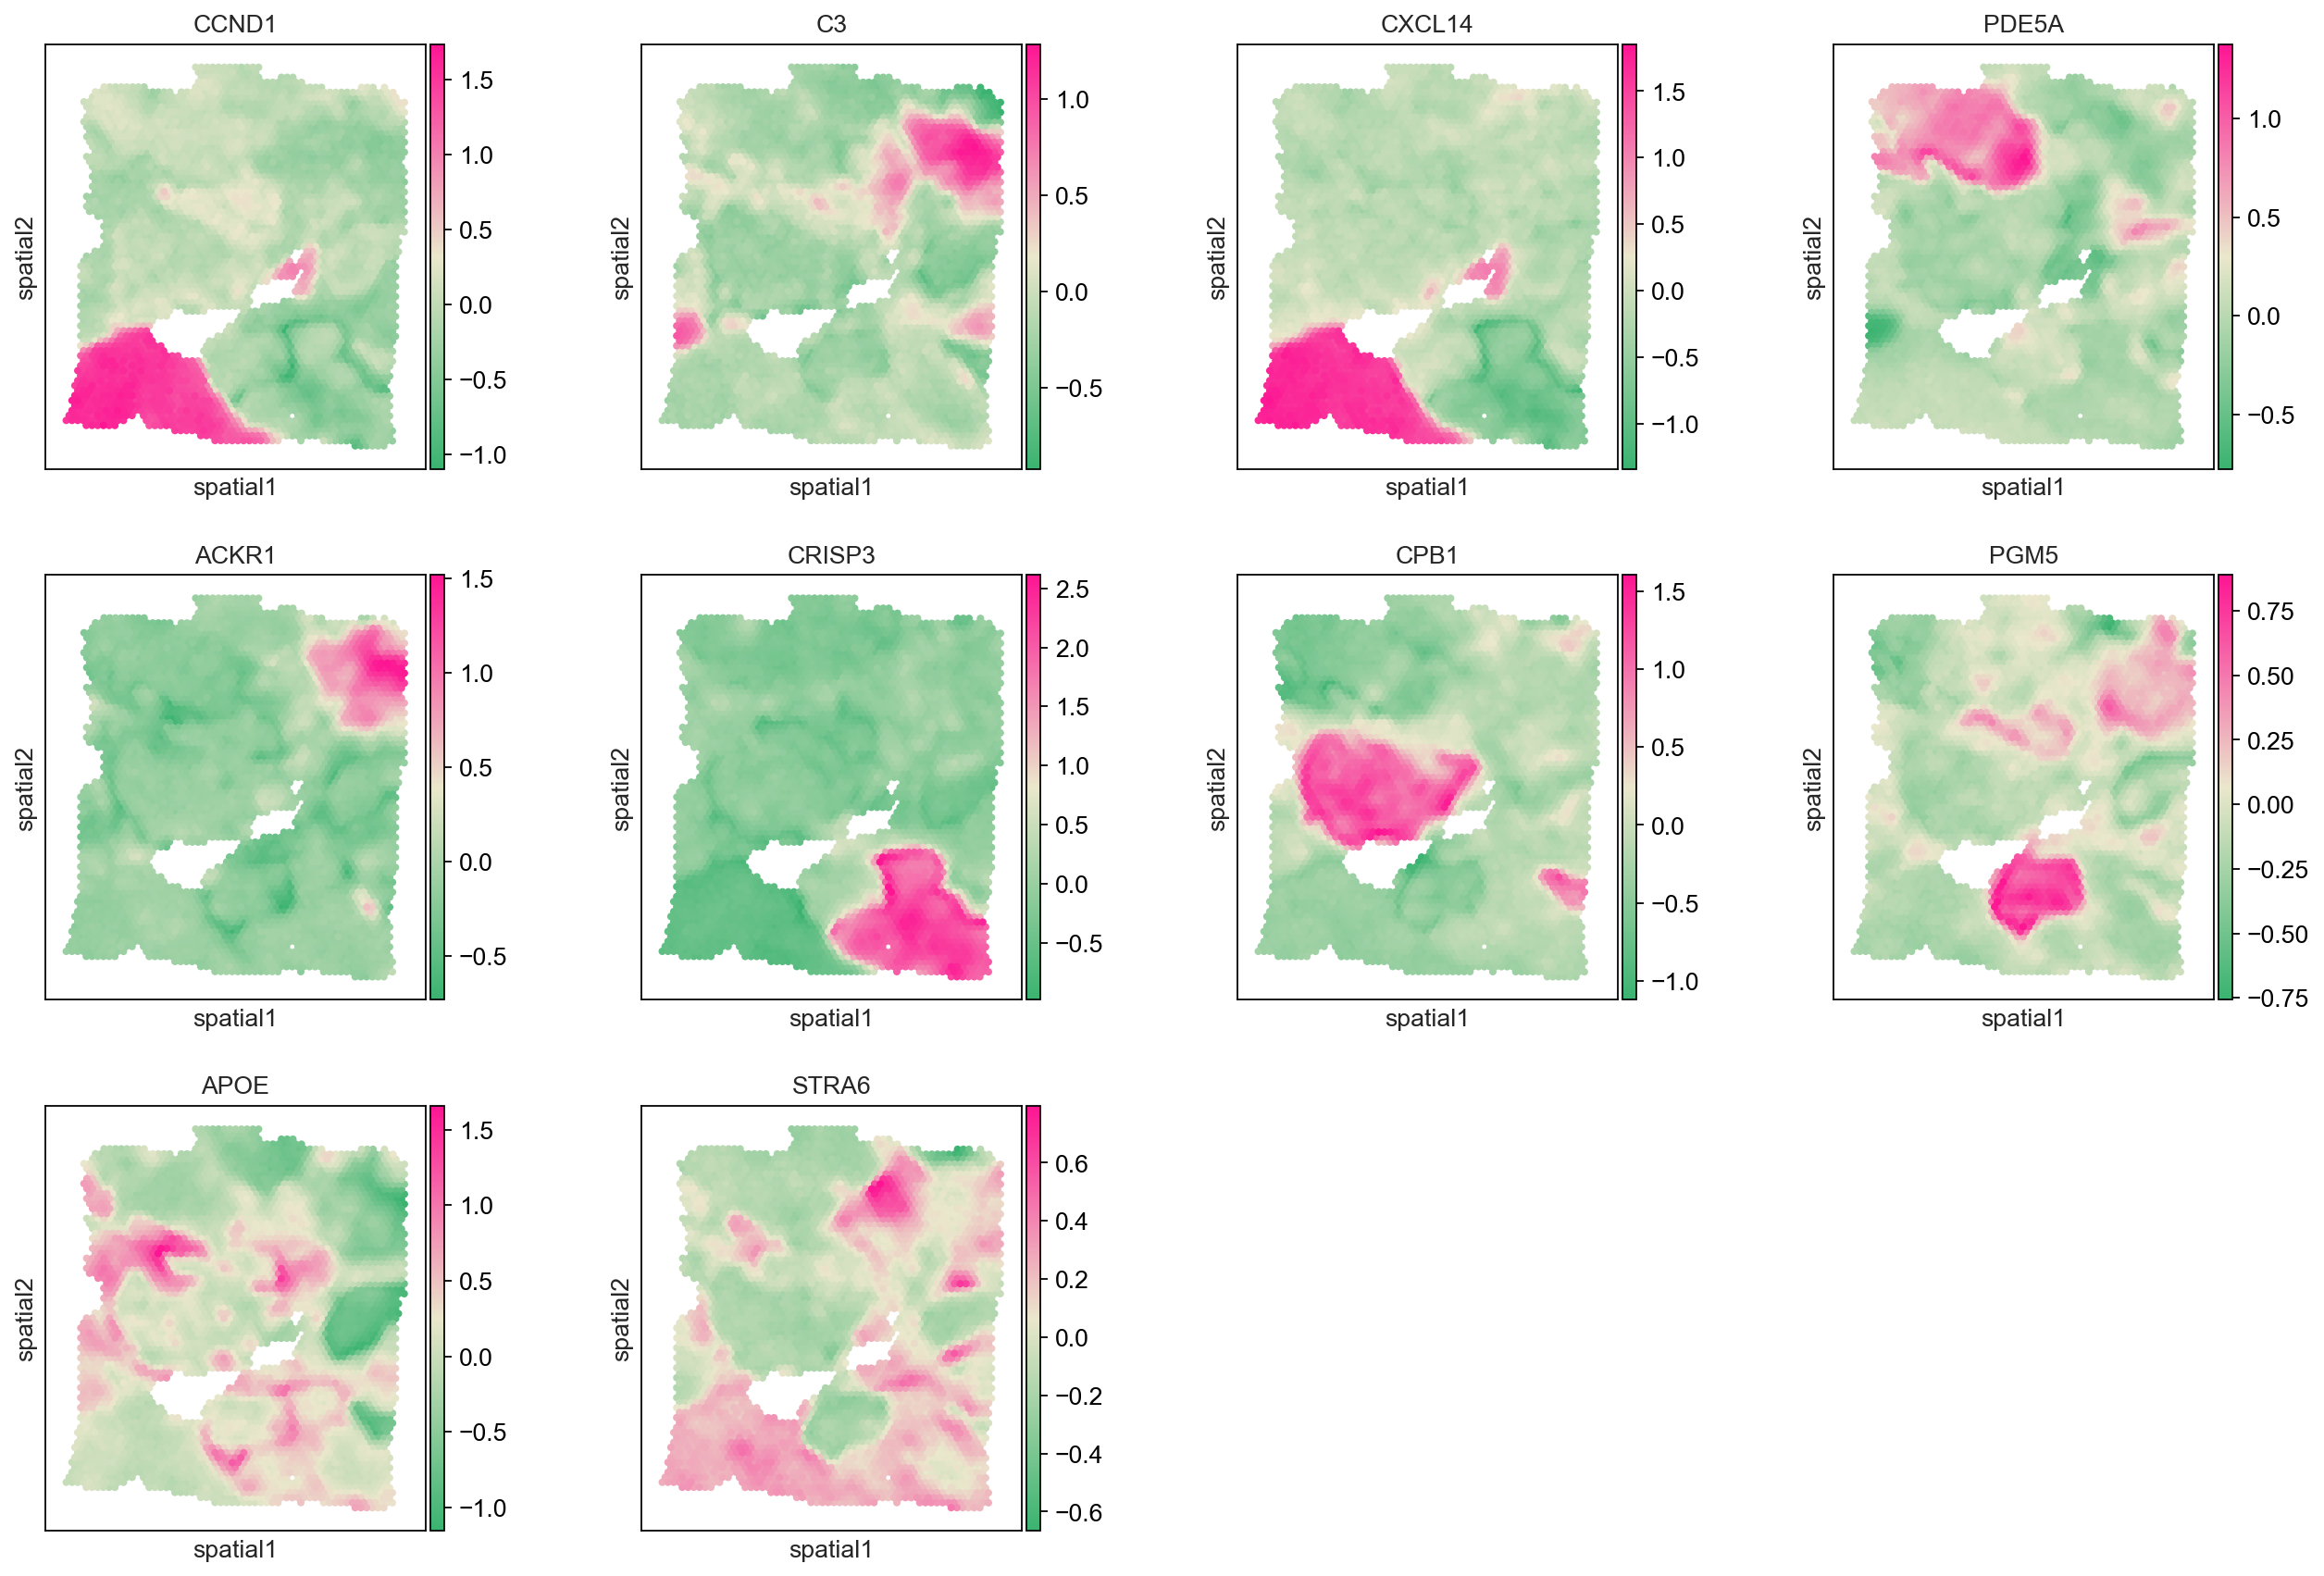

In [27]:
import matplotlib.colors as clr
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=500, frameon=True, vector_friendly=False, fontsize=12, figsize=None, color_map=None, format='eps', facecolor=None, transparent=True, ipython_format='png2x')
sc.pl.spatial(denoised_adata, color=['CCND1','C3','CXCL14','PDE5A','ACKR1','CRISP3','CPB1','PGM5','APOE','STRA6'],color_map=color_self,  alpha_img=0, size=2,save = 'breast10_9')#,save = 'breast10_9'